In [ ]:
# Install Required Libraries
!pip install seaborn opendatasets scikit-learn tensorflow keras --quiet

# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import opendatasets as od
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings

warnings.filterwarnings("ignore")


In [ ]:
# Download Dataset
dataset_url = "https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009"
od.download(dataset_url)

# Load Dataset
df = pd.read_csv("red-wine-quality-cortez-et-al-2009/winequality-red.csv")

Skipping, found downloaded files in "./red-wine-quality-cortez-et-al-2009" (use force=True to force download)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Missing Values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual 

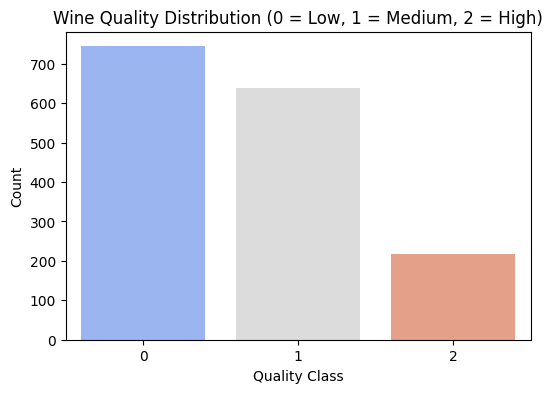

Train shape: (1279, 11), Test shape: (320, 11)


In [ ]:
# Display Initial Data Info
print("Dataset Information:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())

# Convert 'quality' into 3 categories
def categorize_quality(value):
    if value <= 5:
        return 0  # Low Quality
    elif value == 6:
        return 1  # Medium Quality
    else:
        return 2  # High Quality

df["quality"] = df["quality"].apply(categorize_quality)

# Show Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["quality"], palette="coolwarm")
plt.title("Wine Quality Distribution (0 = Low, 1 = Medium, 2 = High)")
plt.xlabel("Quality Class")
plt.ylabel("Count")
plt.show()

# Split Features & Labels
X = df.drop(columns=["quality"])
y = df["quality"]

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (Stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


In [ ]:
# Reshape Data for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], 11, 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 11, 1, 1)

# Build CNN Model for 3-Class Classification
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (2, 1), activation='relu', input_shape=(11, 1, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 1)),

        Conv2D(64, (2, 1), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 1)),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 3 output classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Train CNN Model
cnn_model = build_cnn_model()
history_cnn = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=15, batch_size=16)

# Evaluate CNN Model
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test)


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4825 - loss: 1.4003 - val_accuracy: 0.5250 - val_loss: 1.2230
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5617 - loss: 1.1446 - val_accuracy: 0.5938 - val_loss: 1.1326
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5974 - loss: 1.0671 - val_accuracy: 0.6031 - val_loss: 1.0649
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5997 - loss: 1.0138 - val_accuracy: 0.6187 - val_loss: 1.0175
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5669 - loss: 1.0253 - val_accuracy: 0.6281 - val_loss: 1.0035
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6373 - loss: 0.9609 - val_accuracy: 0.6687 - val_loss: 0.9363
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6514 - loss: 0.9455 - val_accuracy: 0.6469 - val_loss: 0.9153
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6383 - loss: 0.9637 - val_accuracy: 0.6594 - v

In [ ]:
cnn_acc

0.6625000238418579

In [ ]:
# Train Initial Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict with Baseline Model
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model
rf_acc = accuracy_score(y_test, y_pred_rf)

In [ ]:
rf_acc

0.728125

In [ ]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Retrain with Best Parameters
best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluate Tuned Random Forest
y_pred_best_rf = best_rf_model.predict(X_test)
rf_tuned_acc = accuracy_score(y_test, y_pred_best_rf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
rf_tuned_acc

0.740625

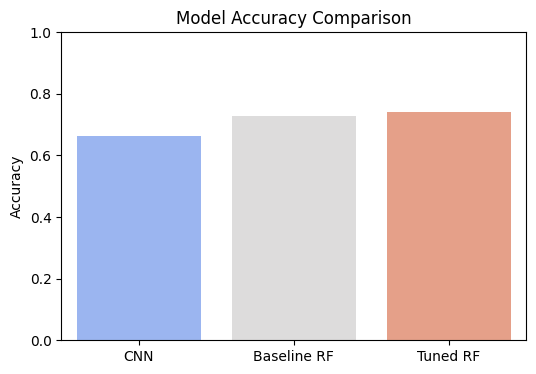

In [ ]:
# Compare All Models
models = ["CNN", "Baseline RF", "Tuned RF"]
accuracies = [cnn_acc, rf_acc, rf_tuned_acc]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies, palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


<Figure size 600x400 with 0 Axes>

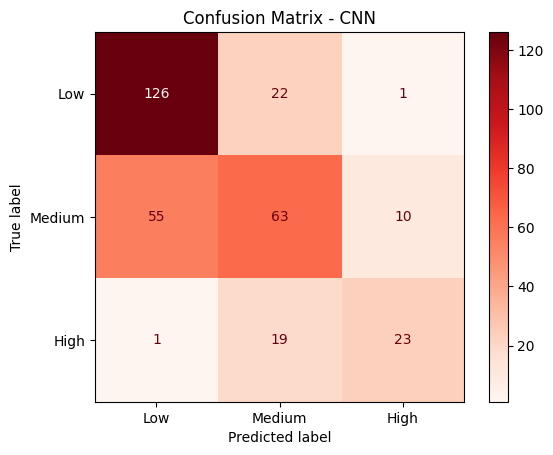

<Figure size 600x400 with 0 Axes>

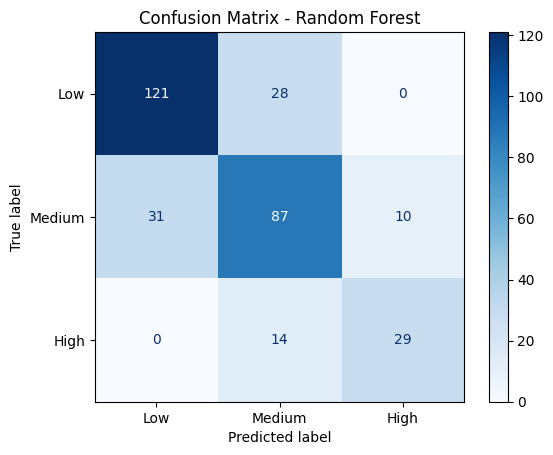

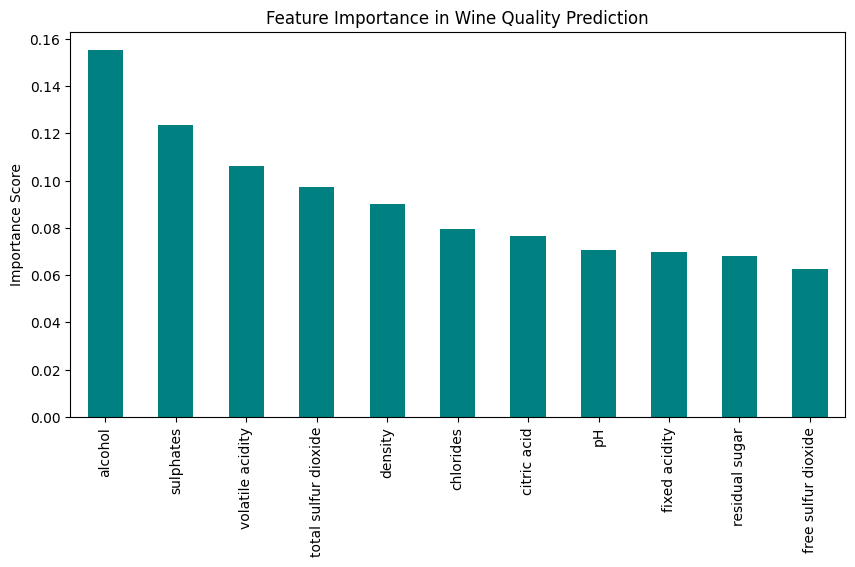

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix for CNN
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_best_rf)

# Plot CNN Confusion Matrix
plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - CNN")
plt.show()

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Feature Importance
feature_importance = pd.Series(best_rf_model.feature_importances_, index=df.drop(columns=["quality"]).columns)
plt.figure(figsize=(10,5))
feature_importance.sort_values(ascending=False).plot(kind="bar", color="teal")
plt.title("Feature Importance in Wine Quality Prediction")
plt.ylabel("Importance Score")
plt.show()


In [ ]:
def predict_wine(sample, true_label):
    sample_scaled = scaler.transform([sample])

    rf_prediction = best_rf_model.predict(sample_scaled)[0]
    cnn_prediction = np.argmax(cnn_model.predict(sample_scaled.reshape(1, 11, 1, 1)), axis=1)[0]

    quality_map = {0: "Low", 1: "Medium", 2: "High"}

    print(f"Random Forest Prediction: {quality_map[rf_prediction]} Quality Wine")
    print(f"CNN Prediction: {quality_map[cnn_prediction]} Quality Wine")
    print(f"Actual Label: {quality_map[true_label]} Quality Wine")

sample_wine = X_test[5]
true_label = y_test.iloc[5]
predict_wine(sample_wine, true_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
🔹 Random Forest Prediction: Medium Quality Wine
🔹 CNN Prediction: Medium Quality Wine
✅ Actual Label: Medium Quality Wine
